In [26]:
# Installing all required python libraries
!pip install --upgrade xgboost
!pip install --upgrade scikit-learn
!pip install --upgrade category_encoders
!pip install optuna
!pip install catboost

In [43]:
#1. Setup and Imports
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder
from xgboost import DMatrix, cv, train
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import combinations

In [44]:
# 2. Data Loading
# Load the dataset
dataset = pd.read_csv('E:\\Studies\\IIT\\4 - Forth Year\\Applied AI\\Course Work\\Dataset  - Main - Allstate Claims Severity\\train.csv')

# Display basic info about the dataset
print("Dataset Info:")
print(dataset.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB
None


In [45]:
# 3. Splitting the Dataset
# Split the dataset into training, validation, and test sets
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

print(f"Training Data Shape: {train_data.shape}")
print(f"Validation Data Shape: {val_data.shape}")
print(f"Test Data Shape: {test_data.shape}")

Training Data Shape: (150654, 132)
Validation Data Shape: (18832, 132)
Test Data Shape: (18832, 132)


In [53]:
# 4. Feature Selection
# Identify numeric columns in the dataset to compute correlations
numeric_data = train_data.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix and focus on correlations with the target variable ('loss')
correlation_matrix = numeric_data.corr()
correlation_with_target = correlation_matrix['loss'].abs()

# Select features that have a strong correlation with the target (greater than 0.1)
selected_features = correlation_with_target[correlation_with_target > 0.1].index.tolist()

# Remove the target variable itself from the list of selected features
selected_features.remove('loss')

# Identify categorical columns in the dataset and add them to the selected features
categorical_columns = [col for col in train_data.columns if train_data[col].dtype == 'object']
selected_features += categorical_columns

# Display the final list of selected features
print("Selected Features:", selected_features)

Selected Features: ['cont2', 'cont3', 'cont7', 'cont11', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', '

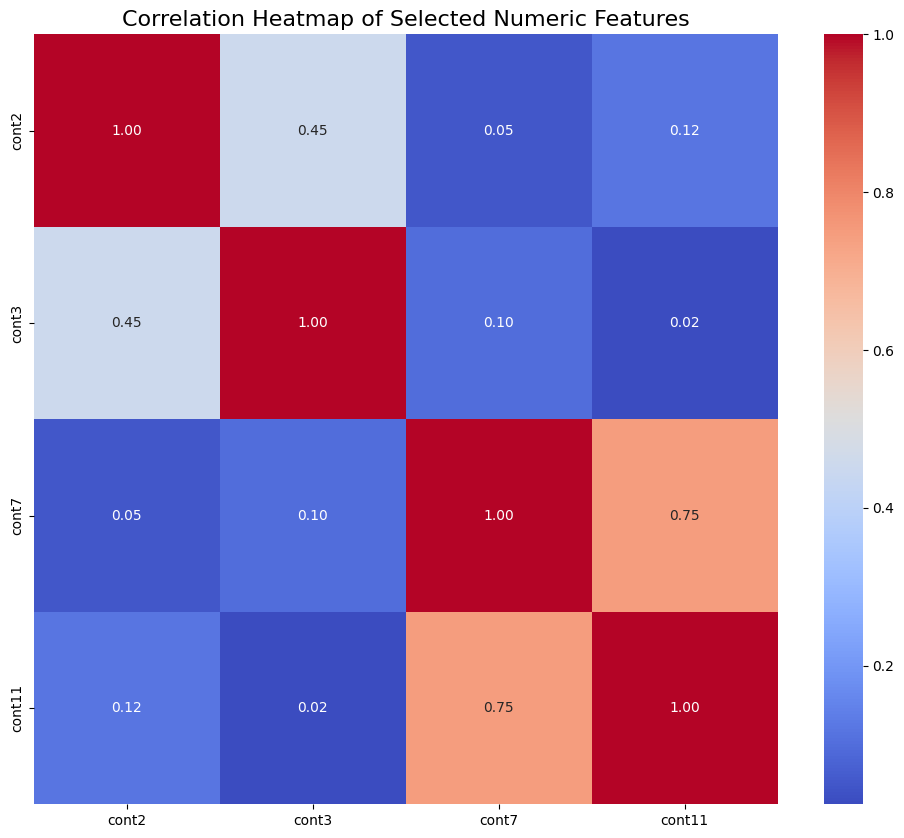

In [54]:
# Correlation Heatmap

# Keep only numeric features from the selected features list, as the correlation matrix is numeric
numeric_selected_features = [col for col in selected_features if col in correlation_matrix.columns]

# Extract the part of the correlation matrix that corresponds to the numeric selected features
filtered_corr_matrix = correlation_matrix.loc[numeric_selected_features, numeric_selected_features]

# Create a heatmap to visualise the correlation between the selected numeric features
plt.figure(figsize=(12, 10))  # Set the figure size for better readability
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")  # Use annot for value display, and coolwarm colormap
plt.title("Correlation Heatmap of Selected Numeric Features", fontsize=16)  # Add a title for context
plt.show()  # Display the heatmap


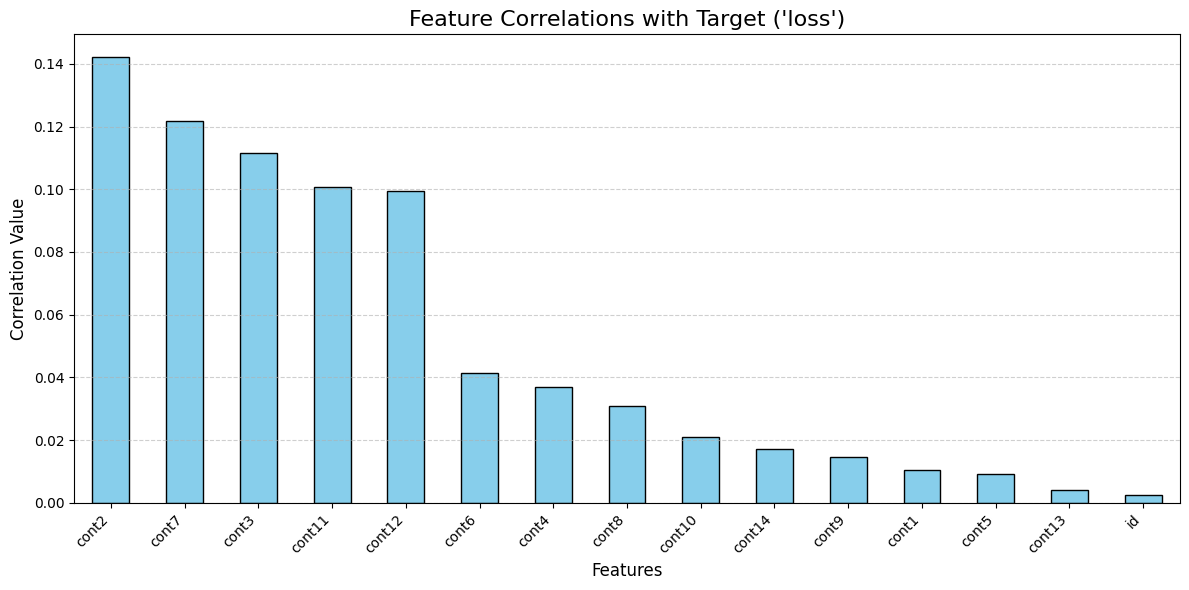

In [ ]:
# 5. Bar Plot of Correlations with 'loss'

# Remove the target ('loss') itself from the correlation values to avoid plotting it
correlation_with_target = correlation_with_target.drop('loss')

# Sort the correlations in descending order for better visualisation
sorted_correlations = correlation_with_target.sort_values(ascending=False)

# Create a bar plot to visualise the correlation of each feature with the target
plt.figure(figsize=(12, 6))  # Set the figure size
sorted_correlations.plot(kind='bar', color='skyblue', edgecolor='k')  # Use a light blue color for bars with black edges
plt.title("Feature Correlations with Target ('loss')", fontsize=16)  # Add a title
plt.ylabel("Correlation Value", fontsize=12)  # Label for the Y-axis
plt.xlabel("Features", fontsize=12)  # Label for the X-axis
plt.xticks(rotation=45, ha='right')  # Rotate the feature names for better readability
plt.grid(axis='y', linestyle='--', alpha=0.6)  # Add a grid to the Y-axis for reference
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()  # Display the plot

In [57]:
# 6. Preprocessing the Data

# Separate the input features and target variable from the dataset
X_train = train_data[selected_features]  # Keep only the selected features
y_train = train_data['loss']  # Target variable

# Identify the categorical columns (object type) and numeric columns (int64 or float64 type)
categorical_columns = [col for col in X_train.columns if X_train[col].dtype == 'object']
numeric_columns = [col for col in X_train.columns if X_train[col].dtype in ['float64', 'int64']]

# Encode the categorical variables into one-hot vectors
encoder = OneHotEncoder(use_cat_names=True)  # Preserve column names in the output
X_train_encoded = encoder.fit_transform(X_train[categorical_columns])  # Transform the categorical columns

# Generate polynomial features for numeric columns to capture interactions between features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_poly = pd.DataFrame(
    poly.fit_transform(X_train[numeric_columns]),  # Apply transformation
    columns=poly.get_feature_names_out(numeric_columns)  # Generate column names for the new features
)

# Scale the numeric features to a range of 0 to 1 for consistency
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_poly), columns=X_train_poly.columns)

# Combine the processed numeric and categorical features into a single dataset
X_train_processed = pd.concat([X_train_scaled, X_train_encoded.reset_index(drop=True)], axis=1)

# Output the shape of the final preprocessed dataset
print("Preprocessed Training Data Shape:", X_train_processed.shape)

c:\Users\Nirusan03\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(
c:\Users\Nirusan03\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(


Preprocessed Training Data Shape: (150654, 1130)


In [58]:
# 7. Outlier Removal

# Reset the indices of the feature set (X_train_processed) and target variable (y_train) to ensure proper alignment
X_train_processed = X_train_processed.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Define thresholds to identify outliers in the target variable ('loss')
loss_threshold_lower = y_train.quantile(0.01)  # Lower 1% of 'loss' values
loss_threshold_upper = y_train.quantile(0.99)  # Upper 1% of 'loss' values

# Create a mask to filter rows where the target variable falls within the defined thresholds
mask = (y_train >= loss_threshold_lower) & (y_train <= loss_threshold_upper)

# Use the mask to remove outliers from both the feature set and the target variable
# .iloc is used to ensure proper alignment of indices
X_train_outlier_removed = X_train_processed.iloc[mask.index[mask]]
y_train_outlier_removed = y_train.iloc[mask.index[mask]]

# Display the shape of the dataset before and after removing outliers
print(f"Original Data Shape: {X_train_processed.shape}, After Outlier Removal: {X_train_outlier_removed.shape}")

Original Data Shape: (150654, 1130), After Outlier Removal: (147640, 1130)


In [59]:
# 8. Feature Engineering

# Define the chunk size to process the data in smaller batches
chunk_size = 10000

# Initialize the PolynomialFeatures transformer to generate interaction terms
# - degree=2: Generate pairwise interaction terms
# - interaction_only=True: Exclude self-interactions (e.g., x^2)
# - include_bias=False: Exclude the bias term
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# Initialize an empty list to store the polynomial features from each batch
poly_features = []

# Process the dataset in chunks to avoid memory issues
for i in range(0, X_train_outlier_removed.shape[0], chunk_size):
    # Extract a batch of data as a NumPy array for processing
    batch_data = X_train_outlier_removed.iloc[i : i + chunk_size].to_numpy()
    
    # Generate polynomial features for the first 50 columns (limiting to reduce complexity)
    batch_poly = poly.fit_transform(batch_data[:, :50])
    
    # Append the processed batch to the list
    poly_features.append(batch_poly)

# Combine all the processed chunks into a single NumPy array
X_train_poly = np.vstack(poly_features)

# Apply RobustScaler to normalize the features and handle outliers effectively
scaler = RobustScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)

# Print the shape of the enhanced feature set
print(f"Enhanced Feature Shape: {X_train_poly_scaled.shape}")

Enhanced Feature Shape: (147640, 1275)


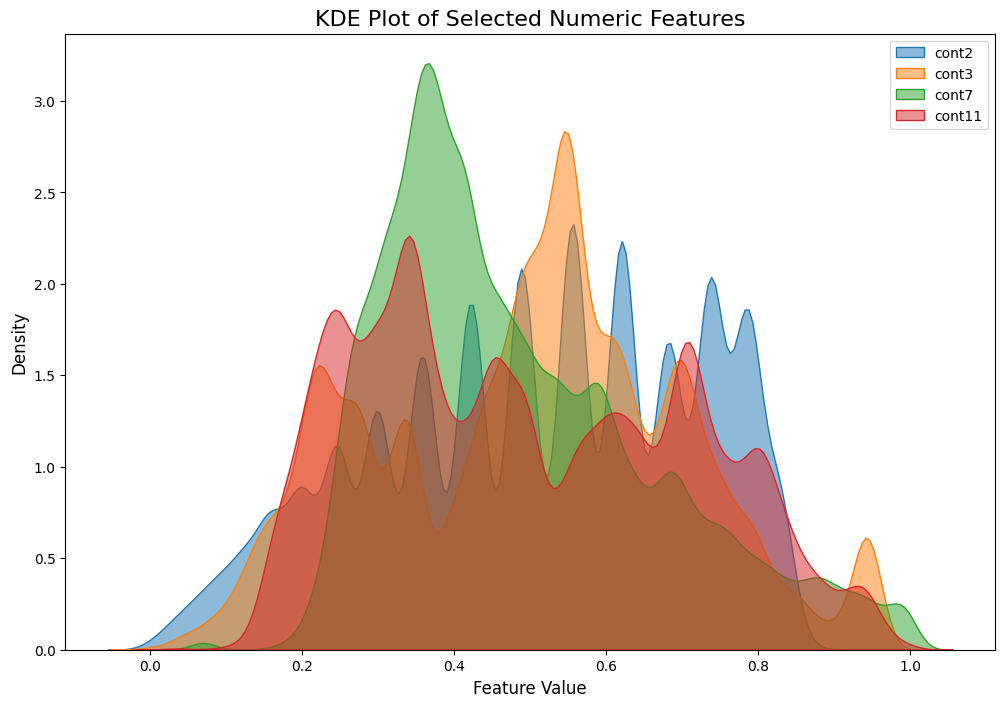

In [60]:
# 9. Plot KDE for Selected Numeric Features

# Create a figure to display the KDE (Kernel Density Estimation) plots
plt.figure(figsize=(12, 8))

# Iterate over the first 5 selected features that are numeric
for col in selected_features[:5]:  
    # Check if the column exists in the numeric data
    if col in numeric_data.columns:
        # Plot the KDE for the selected feature
        sns.kdeplot(
            data=train_data,    # Dataset containing the feature
            x=col,              # Feature to plot
            fill=True,          # Fill the area under the KDE curve
            label=col,          # Add the feature name as a legend label
            alpha=0.5           # Set transparency for better readability
        )

# Add a title to the plot
plt.title("KDE Plot of Selected Numeric Features", fontsize=16)

# Add labels to the x-axis and y-axis
plt.xlabel("Feature Value", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Display the legend to identify each feature
plt.legend()

# Show the plot
plt.show()

In [61]:
# 10. Hyperparameter Tuning
# Reduce dataset size for tuning
sample_fraction = 0.1  # Use 10% of the data
X_train_sampled = X_train_outlier_removed.sample(frac=sample_fraction, random_state=42)
y_train_sampled = y_train_outlier_removed.sample(frac=sample_fraction, random_state=42)

# Convert sampled data to DMatrix for XGBoost
dtrain_sampled = DMatrix(X_train_sampled, label=y_train_sampled)

# Define the objective function for Optuna
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 6),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 0.8),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 1.0, log=True),
    }
    # Perform cross-validation
    cv_results = cv(
        params=params,
        dtrain=dtrain_sampled,
        num_boost_round=50,
        nfold=3,
        metrics="rmse",
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    return cv_results["test-rmse-mean"].min()

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Best parameters and score
best_params = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params)
print("Best RMSE:", best_score)

[I 2025-01-07 18:09:28,607] A new study created in memory with name: no-name-0affb245-7ec4-46ba-a3b1-15c0ba90bded
[I 2025-01-07 18:09:32,541] Trial 0 finished with value: 1869.3911606834972 and parameters: {'max_depth': 4, 'learning_rate': 0.024419410002827026, 'subsample': 0.6626435668273302, 'reg_alpha': 0.41864121690024314, 'reg_lambda': 0.8569396819336741}. Best is trial 0 with value: 1869.3911606834972.
[I 2025-01-07 18:09:35,533] Trial 1 finished with value: 2021.8333320793897 and parameters: {'max_depth': 3, 'learning_rate': 0.014444156103552212, 'subsample': 0.6710694269810201, 'reg_alpha': 0.16108465892267693, 'reg_lambda': 0.35126828099607005}. Best is trial 0 with value: 1869.3911606834972.
[I 2025-01-07 18:09:38,661] Trial 2 finished with value: 1955.5459075531753 and parameters: {'max_depth': 5, 'learning_rate': 0.01494242769519972, 'subsample': 0.6309698142314413, 'reg_alpha': 0.7856155989072414, 'reg_lambda': 0.15237200696425365}. Best is trial 0 with value: 1869.3911606

Best Parameters: {'max_depth': 6, 'learning_rate': 0.0975382689766109, 'subsample': 0.7819933109166894, 'reg_alpha': 0.3550736939546948, 'reg_lambda': 0.2200011958753299}
Best RMSE: 1658.75862345067


In [ ]:
# 11. Train Ensemble Models

# Train the XGBoost Model
# Create a DMatrix for the XGBoost model using the processed training data
dtrain_full = DMatrix(X_train_outlier_removed, label=y_train_outlier_removed)

# Prepare the parameters for XGBoost, removing any incompatible ones
xgb_params = best_params.copy()
xgb_params.pop('colsample_bytree', None)  # Remove 'colsample_bytree' as it's not applicable to XGBoost

# Train the XGBoost model with the specified parameters
xgb_model = train(
    xgb_params,         # Model parameters
    dtrain_full,        # Training data
    num_boost_round=500 # Number of boosting rounds
)

# Train the LightGBM Model
# Create a LightGBM Regressor with the best parameters
lgb_model = LGBMRegressor(**best_params, n_estimators=500)

# Fit the LightGBM model to the processed training data
lgb_model.fit(X_train_outlier_removed, y_train_outlier_removed)

# Train the CatBoost Model
# Define parameters specific to CatBoost
cat_params = {
    'learning_rate': best_params['learning_rate'],       # Use learning rate from the best parameters
    'depth': best_params.get('max_depth', 6),            # Use max_depth as depth
    'l2_leaf_reg': best_params.get('reg_lambda', 3),     # Equivalent to reg_lambda in CatBoost
    'iterations': 500,                                   # Number of training iterations
    'verbose': False                                     # Suppress verbose output
}

# Create a CatBoost Regressor with the defined parameters
cat_model = CatBoostRegressor(**cat_params)

# Fit the CatBoost model to the processed training data
cat_model.fit(X_train_outlier_removed, y_train_outlier_removed)

# Print a message indicating that all models have been trained successfully
print("Models trained successfully!")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4313
[LightGBM] [Info] Number of data points in the train set: 147640, number of used features: 827
[LightGBM] [Info] Start training from score 2908.994806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [63]:
# 12. Feature Importance

# Extract feature importance from the XGBoost model
# The importance type 'weight' represents the number of times a feature is used in splits
feature_importances_xgb = xgb_model.get_score(importance_type='weight')

# Extract feature importance from the LightGBM model
# Use the feature_importances_ attribute and retrieve the corresponding feature names
feature_importances_lgb = lgb_model.feature_importances_
features_lgb = X_train_outlier_removed.columns.tolist()

# Extract feature importance from the CatBoost model
# Use the get_feature_importance method for CatBoost
feature_importances_cat = cat_model.get_feature_importance()
features_cat = X_train_outlier_removed.columns.tolist()

# Combine the feature importances from all models
# Use the union of feature sets across models and calculate the average importance
all_features = list(set(feature_importances_xgb.keys()).union(features_lgb).union(features_cat))
combined_importance = {
    feature: (
        feature_importances_xgb.get(feature, 0) +  # Importance from XGBoost
        (feature_importances_lgb[features_lgb.index(feature)] if feature in features_lgb else 0) +  # LightGBM
        (feature_importances_cat[features_cat.index(feature)] if feature in features_cat else 0)  # CatBoost
    ) / 3  # Average importance across models
    for feature in all_features
}

# Convert the combined feature importances into a pandas DataFrame for easier analysis
important_features = pd.DataFrame({
    'Feature': list(combined_importance.keys()),         # Feature names
    'Importance': list(combined_importance.values())     # Corresponding importance values
}).sort_values(by='Importance', ascending=False)         # Sort by importance in descending order

# Display the top 10 most important features
print("Top 10 Important Features:")
print(important_features.head(10))

Top 10 Important Features:
           Feature  Importance
977          cont2  604.410873
926    cont2 cont7  496.980183
83           cont7  466.535763
1022   cont3 cont7  350.506827
221    cont2 cont3  343.667080
763   cont2 cont11  314.495334
935          cont3  294.386722
245         cont11  233.112433
555   cont3 cont11  212.759356
553   cont7 cont11  204.464353


In [64]:
# 13. Model Evaluation

# Import necessary metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Generate predictions for each individual model:
# Use the XGBoost model to predict on the processed training data
xgb_predictions = xgb_model.predict(DMatrix(X_train_outlier_removed))

# Use the LightGBM model to predict on the processed training data
lgb_predictions = lgb_model.predict(X_train_outlier_removed)

# Use the CatBoost model to predict on the processed training data
cat_predictions = cat_model.predict(X_train_outlier_removed)

# Combine predictions from all models using a weighted average
# Adjust ensemble_weights if necessary for better performance
ensemble_weights = [0.33, 0.33, 0.34]  # Example weights
ensemble_predictions = (
    ensemble_weights[0] * xgb_predictions +
    ensemble_weights[1] * lgb_predictions +
    ensemble_weights[2] * cat_predictions
)

# Calculate evaluation metrics to assess model performance
rmse = np.sqrt(mean_squared_error(y_train_outlier_removed, ensemble_predictions))  # Root Mean Squared Error
mae = mean_absolute_error(y_train_outlier_removed, ensemble_predictions)          # Mean Absolute Error
r2 = r2_score(y_train_outlier_removed, ensemble_predictions)                      # R² Score

# Print the evaluation metrics for the improved ensemble model
print("Evaluation Metrics for the Improved Ensemble:")
print(f"RMSE: {rmse:.4f}")  # Display RMSE with 4 decimal places
print(f"MAE: {mae:.4f}")    # Display MAE with 4 decimal places
print(f"R² Score: {r2:.4f}") # Display R² score with 4 decimal places

# Calculate accuracy metrics:
# Percentage accuracy within ±10% of actual values
percentage_error = np.abs((y_train_outlier_removed - ensemble_predictions) / y_train_outlier_removed) * 100
accuracy_within_10 = (percentage_error <= 10).mean() * 100
print(f"Accuracy within ±10% of actual: {accuracy_within_10:.2f}%")

# Fixed accuracy within a range of ±500 of actual values
accuracy_within_500 = (np.abs(y_train_outlier_removed - ensemble_predictions) <= 500).mean() * 100
print(f"Accuracy within ±500 of actual: {accuracy_within_500:.2f}%")

Evaluation Metrics for the Improved Ensemble:
RMSE: 1453.2045
MAE: 1030.7975
R² Score: 0.6294
Accuracy within ±10% of actual: 16.37%
Accuracy within ±500 of actual: 35.57%


In [66]:
# 14. Save Results
# Save actual and predicted values to a CSV file
comparison_df = pd.DataFrame({
    'Actual Loss': y_train_outlier_removed,
    'Predicted Loss': ensemble_predictions
})
comparison_csv_path = 'ensemble_predictions.csv'
comparison_df.to_csv(comparison_csv_path, index=False)

print(f"Comparison results saved to: {comparison_csv_path}")

Comparison results saved to: ensemble_predictions.csv


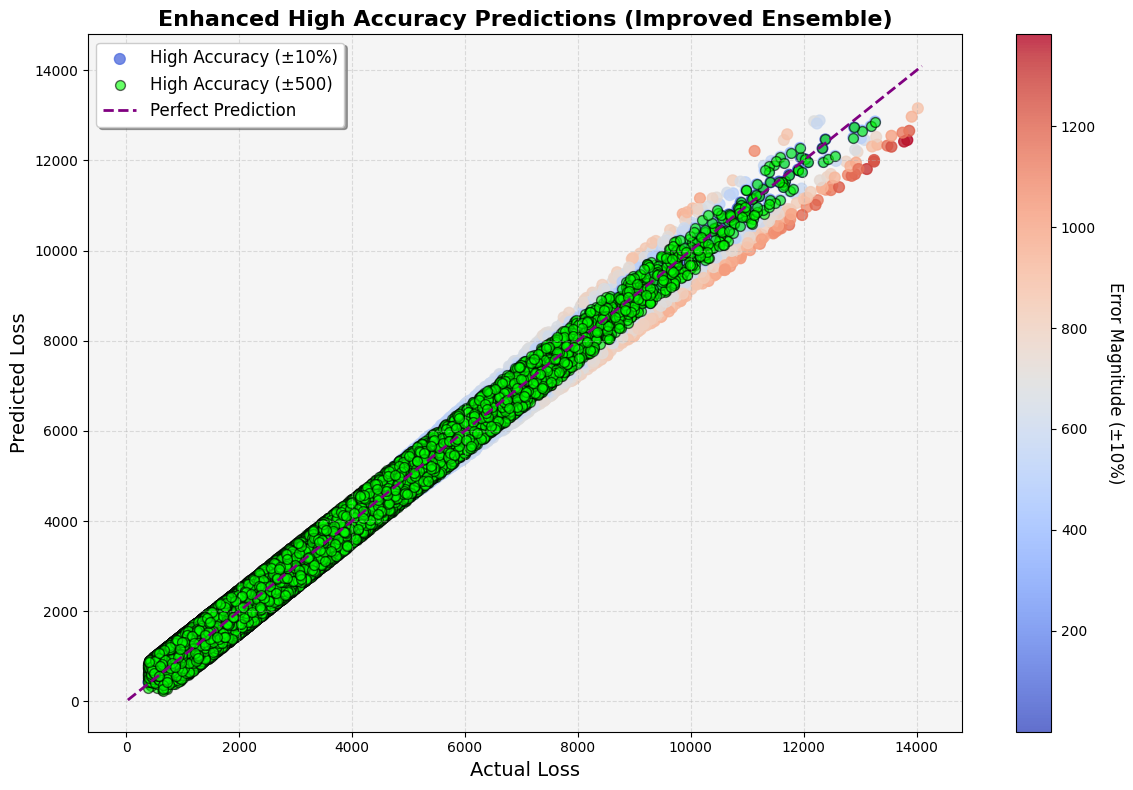

In [67]:
# 15. Scatter plot visualizatoin
import matplotlib.pyplot as plt
import numpy as np

# Calculate percentage error
percentage_error = np.abs((y_train_outlier_removed - ensemble_predictions) / y_train_outlier_removed) * 100

# Filter data for ±10% and ±500 ranges
high_accuracy_10_indices = percentage_error <= 10
high_accuracy_500_indices = np.abs(y_train_outlier_removed - ensemble_predictions) <= 500

# Data for ±10% accuracy
actual_high_accuracy_10 = y_train_outlier_removed[high_accuracy_10_indices]
predicted_high_accuracy_10 = ensemble_predictions[high_accuracy_10_indices]

# Data for ±500 accuracy
actual_high_accuracy_500 = y_train_outlier_removed[high_accuracy_500_indices]
predicted_high_accuracy_500 = ensemble_predictions[high_accuracy_500_indices]

# Create the plot
plt.figure(figsize=(12, 8))

# High Accuracy (±10%) with a gradient colormap
scatter_10 = plt.scatter(
    actual_high_accuracy_10,
    predicted_high_accuracy_10,
    c=np.abs(actual_high_accuracy_10 - predicted_high_accuracy_10),
    cmap='coolwarm',  # Gradient colormap
    alpha=0.8,
    s=60,  # Size of the points
    label="High Accuracy (±10%)"
)

# High Accuracy (±500) with a distinct color
plt.scatter(
    actual_high_accuracy_500,
    predicted_high_accuracy_500,
    alpha=0.6,
    s=50,
    color="lime",
    edgecolor="k",
    label="High Accuracy (±500)"
)

# Add a colorbar for the ±10% gradient
cbar = plt.colorbar(scatter_10)
cbar.set_label("Error Magnitude (±10%)", rotation=270, labelpad=20, fontsize=12)

# Add diagonal reference line for perfect predictions
min_value = min(min(y_train_outlier_removed), min(ensemble_predictions))
max_value = max(max(y_train_outlier_removed), max(ensemble_predictions))
plt.plot([min_value, max_value], [min_value, max_value], color="purple", linestyle="--", linewidth=2, label="Perfect Prediction")

# Add labels, title, and legend
plt.xlabel("Actual Loss", fontsize=14)
plt.ylabel("Predicted Loss", fontsize=14)
plt.title("Enhanced High Accuracy Predictions (Improved Ensemble)", fontsize=16, fontweight="bold")
plt.legend(fontsize=12, loc="upper left", shadow=True, fancybox=True)
plt.grid(True, linestyle="--", alpha=0.4)

# Add a stylish background
plt.gca().set_facecolor("#f5f5f5")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()